This example demonstrates how to do structured data classification, starting from a raw CSV file. Our data includes both numerical and categorical features. We will use Keras preprocessing layers to normalize the numerical features and vectorize the categorical ones.
https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

In [28]:
import tensorflow as tf 
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [29]:
#Should be run with TensorFlow 2.5 or higher
print(tf.__version__)

2.6.3


In [30]:
#Download the data and load it into a Pandas dataframe
file_dir="../input/heart-disease-cleveland-uci/heart_cleveland_upload.csv"
df = pd.read_csv(file_dir)

In [31]:
#Dataset has 297 sample with 14 columns
df.shape

(297, 14)

Each row contains information about a patient (a sample), and each column describes an attribute of the patient (a feature). We use the features to predict whether a patient has a heart disease (binary classification).

* Age Age in years Numerical
* Sex	(1 = male; 0 = female)	Categorical
* CP	Chest pain type (0, 1, 2, 3, 4)	Categorical
* Trestbpd	Resting blood pressure (in mm Hg on admission)	Numerical
* Chol	Serum cholesterol in mg/dl	Numerical
* FBS	fasting blood sugar in 120 mg/dl (1 = true; 0 = false)	Categorical
* RestECG	Resting electrocardiogram results (0, 1, 2)	Categorical
* Thalach	Maximum heart rate achieved	Numerical
* Exang	Exercise induced angina (1 = yes; 0 = no)	Categorical
* Oldpeak	ST depression induced by exercise relative to rest	Numerical
* Slope	Slope of the peak exercise ST segment	Numerical
* CA	Number of major vessels (0-3) colored by fluoroscopy	Both numerical & categorical
* Thal	0 = normal; 1 = fixed defect; 2 = reversible defect	Categorical
* Target	Diagnosis of heart disease (1 = true; 0 = false)	Target

In [32]:
#Sample of the dataframe
#Last column, "target", indicates whether the patient has a heart disease (1) or not (0).
df.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
82,66,0,2,146,278,0,2,152,0,0.0,1,1,0,0
225,57,1,3,165,289,1,2,124,0,1.0,1,3,2,1
287,42,0,3,102,265,0,2,122,0,0.6,1,0,0,0
277,45,1,3,142,309,0,2,147,1,0.0,1,3,2,1
48,52,1,1,128,205,1,0,184,0,0.0,0,0,0,0


In [33]:
#Split the data into a training and validation set
val_df = df.sample(frac=0.2, random_state=1337)
train_df = df.drop(val_df.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_df), len(val_df))
)

Using 238 samples for training and 59 for validation


In [34]:
#Generate tf.data.Dataset objects for each dataframe
def dataframe_to_dataset(df):
    df = df.copy()
    labels = df.pop("condition")
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds


train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_df)

In [35]:
#Each Dataset yields a tuple (input, condition) 
#input is a dictionary of features
#condition is the value 0 or 1
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Condition:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=57>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=126>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=173>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.2>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'thal': <tf.Tensor: shape=(), dtype=int64, numpy=2>}
Condition: tf.Tensor(0, shape=(), dtype=int64)


In [36]:
#Batch the datasets
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [37]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

#encode_numerical_feature to apply featurewise normalization to numerical features.
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

#encode_categorical_feature to first turn string inputs into integer indices, then one-hot encode these integer indices.
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [38]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")
thal = keras.Input(shape=(1,), name="thal", dtype="int64")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, False)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sex (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
cp (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
fbs (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
restecg (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

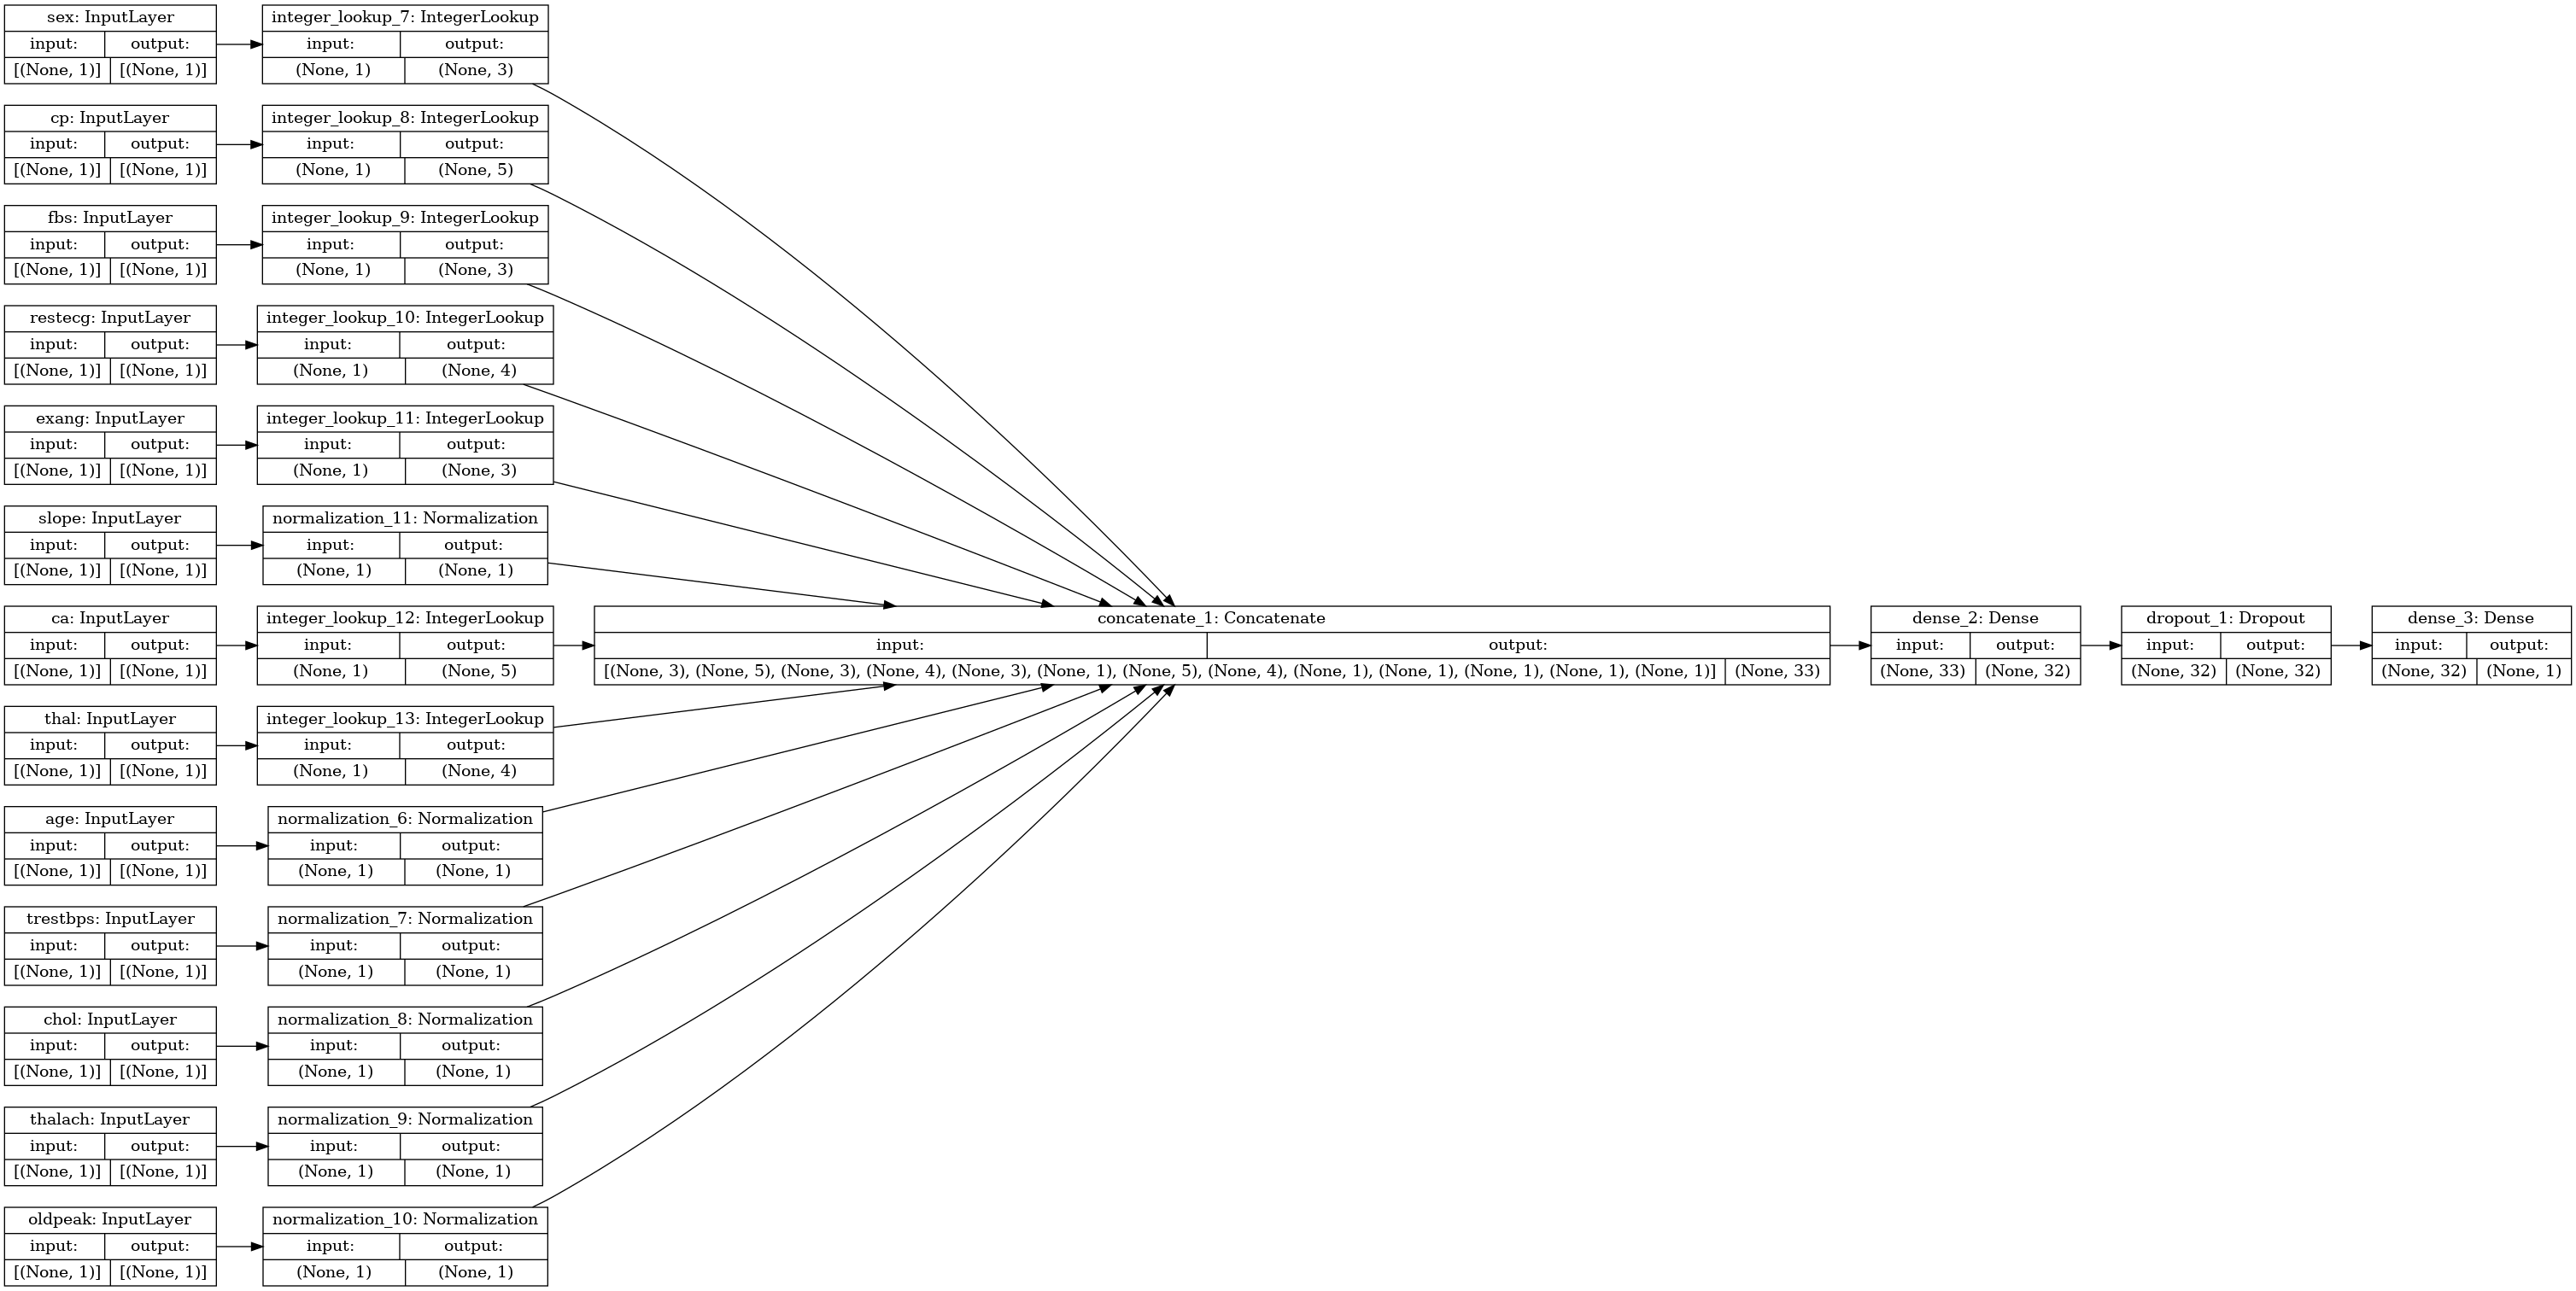

In [40]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [49]:
checkpoint_filepath = '../output/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_ds, epochs=10, batch_size= 32, validation_data=val_ds, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/10
8/8 [==============================] - 0s 7ms/step - loss: 0.4067 - accuracy: 0.8193 - val_loss: 0.4133 - val_accuracy: 0.8475
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 0.4318 - accuracy: 0.7983 - val_loss: 0.4108 - val_accuracy: 0.8475
Epoch 3/10
8/8 [==============================] - 0s 7ms/step - loss: 0.3981 - accuracy: 0.8361 - val_loss: 0.4100 - val_accuracy: 0.8475
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.4005 - accuracy: 0.8277 - val_loss: 0.4074 - val_accuracy: 0.8475
Epoch 5/10
8/8 [==============================] - 0s 8ms/step - loss: 0.3938 - accuracy: 0.8109 - val_loss: 0.4049 - val_accuracy: 0.8475
Epoch 6/10
8/8 [==============================] - 0s 7ms/step - loss: 0.3835 - accuracy: 0.8361 - val_loss: 0.4043 - val_accuracy: 0.8475
Epoch 7/10
8/8 [==============================] - 0s 6ms/step - loss: 0.3731 - accuracy: 0.8403 - val_loss: 0.4044 - val_accuracy: 0.8475
Epoch 8/10
8/8 [==================

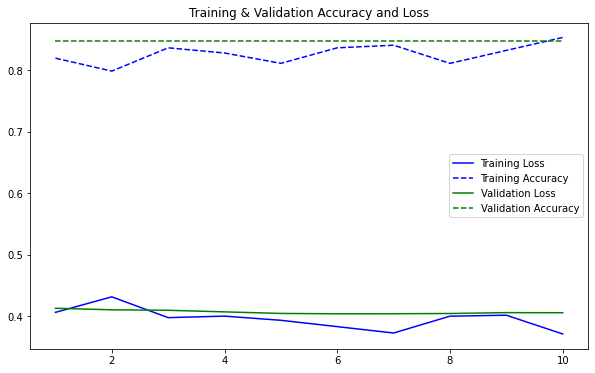

In [50]:
#Plot accuracy and loss curves
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["loss"]) + 1)

plt.rcParams["figure.figsize"] = (10,6)

train_loss = history.history["loss"]
train_acc = history.history["accuracy"]
plt.plot(epochs, train_loss, "-b", label = "Training Loss")
plt.plot(epochs, train_acc, "--b", label = "Training Accuracy")

val_los = history.history["val_loss"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, val_los, "-g", label = "Validation Loss")
plt.plot(epochs, val_acc, "--g", label = "Validation Accuracy")

plt.title("Training & Validation Accuracy and Loss")
plt.legend()

In [56]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 80.6 percent probability of having a heart disease, as evaluated by our model.
